In [1]:
import json
import generate_figures as gf

batch_file = '../data/json/cedar_batch_total_dedicated_nt_4d_2.json'
pilots8_file = '../data/json/cedar_pilots8_total_dedicated_nt_4d_2.json'
pilots16_file = '../data/json/cedar_pilots16_total_dedicated_nt_4d_2.json'

gf.batch = gf.load_json(batch_file)
gf.pilots8 = gf.load_json(pilots8_file)
gf.pilots16 = gf.load_json(pilots16_file)

In [2]:
#get makespans
assert(len(gf.batch)==len(gf.pilots8)==len(gf.pilots16))

dedicated_1 = gf.makespan_dict()
dedicated_2 = gf.makespan_dict()
dedicated_3 = gf.makespan_dict()
dedicated_4 = gf.makespan_dict()

gf.fill_dictionaries()
        

## FIGURE 0 - RAW

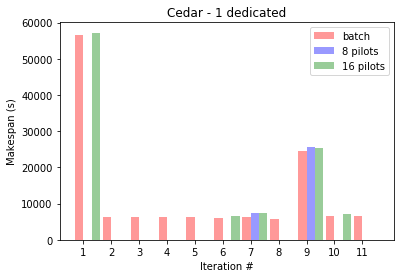

In [3]:
## 1 dedicated
gf.iteration_fig(gf.dedicated_1, 1, system="Cedar")

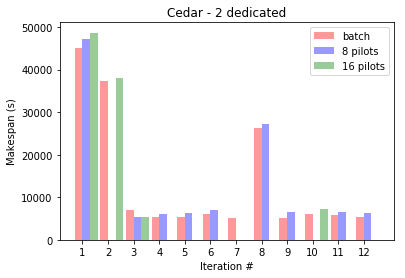

In [4]:
## 2 dedicated
gf.iteration_fig(gf.dedicated_2, 2, system="Cedar")

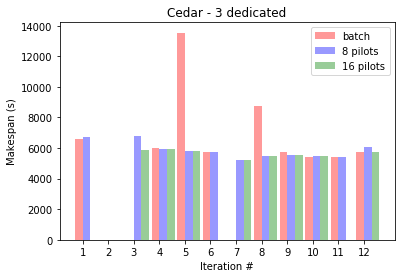

In [5]:
## 3 dedicated
gf.iteration_fig(gf.dedicated_3, 3, system="Cedar")

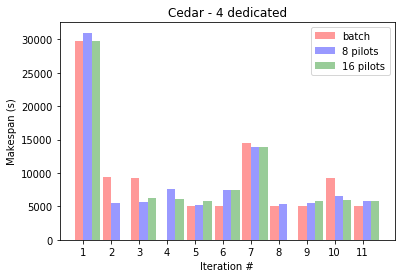

In [6]:
## 4 dedicated
gf.iteration_fig(gf.dedicated_4, 4, system="Cedar")

## FIGURE 1 - Makespan difference

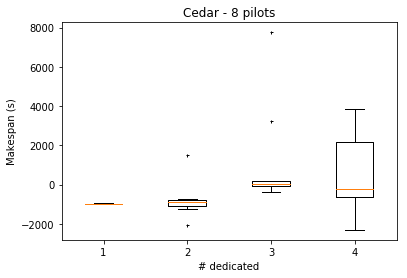

In [7]:
gf.makespan_box(gf.dedicated_1, gf.dedicated_2,
                gf.dedicated_3, gf.dedicated_4, 8, system="Cedar")

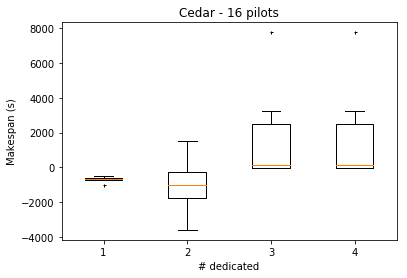

In [8]:
gf.makespan_box(gf.dedicated_1, gf.dedicated_2,
                gf.dedicated_3, gf.dedicated_3, 16, system="Cedar")

## Figure 2 - Queuing time difference

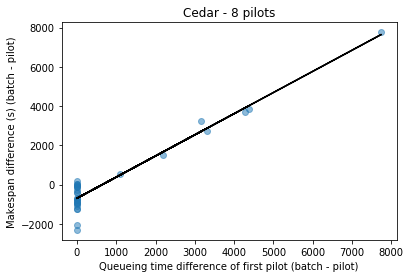

In [9]:
# Beluga 8 pilots
qxlabel = "Queueing time difference of first pilot (batch - pilot)"
qylabel = "Makespan difference (s) (batch - pilot)"

gf.scatter_fig(*gf.makespan_queue(8), num_pilots=8,
               xlabel=qxlabel, ylabel=qylabel, system="Cedar")


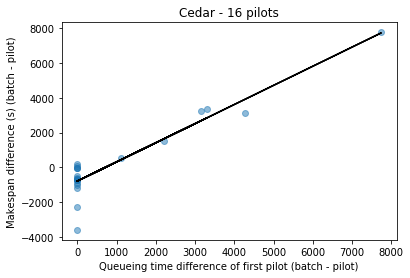

In [10]:
#Beluga 16 pilots
gf.scatter_fig(*gf.makespan_queue(16), num_pilots=16,
               xlabel=qxlabel, ylabel=qylabel, system="Cedar")

## Figure 3A - Average number of nodes

In [11]:
avgn_8pilots = [gf.get_pilot_avgnodes(job, gf.batch[idx])
                for idx, job in enumerate(gf.pilots8)
                if job['success']
                and job['end_time'] is not None
                and gf.batch[idx]['success']
                and gf.batch[idx]['end_time'] is not None]
avgn_16pilots = [gf.get_pilot_avgnodes(job, gf.batch[idx])
                 for idx, job in enumerate(gf.pilots16)
                 if job['success']
                 and job['end_time'] is not None
                 and gf.batch[idx]['success']
                 and gf.batch[idx]['end_time'] is not None]
avgn_batch = [gf.get_batch_avgnodes(job)
              for job in gf.batch 
              if job['success'] and job['end_time'] is not None]

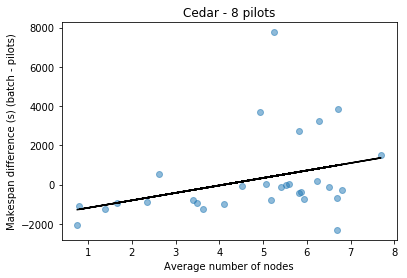

In [12]:
# 8 pilots
as_xlbl = "Average number of {}"
as_ylbl = "Makespan difference (s) (batch - pilots)"
gf.scatter_fig([i[0] for i in avgn_8pilots],
               [i[1] for i in avgn_8pilots], 8,
               xlabel=as_xlbl.format("nodes"),
               ylabel=as_ylbl, system="Cedar")

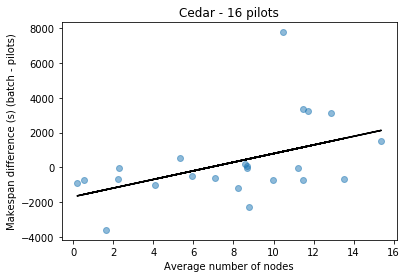

In [13]:
# 16 pilots
gf.scatter_fig([i[0] for i in avgn_16pilots],
               [i[1] for i in avgn_16pilots], 16,
               xlabel=as_xlbl.format("nodes"),
               ylabel=as_ylbl, system="Cedar")

## Figure 3B - Average number of pilots

In [14]:
avgp_8pilots = [gf.get_avgpilots(job, gf.batch[idx])
               for idx, job in enumerate(gf.pilots8)
               if job['success']
                and job['end_time'] is not None
                and gf.batch[idx]['success']]
avgp_16pilots = [gf.get_avgpilots(job, gf.batch[idx])
                for idx, job in enumerate(gf.pilots16)
                if job['success']
                 and job['end_time'] is not None
                 and gf.batch[idx]['success']]

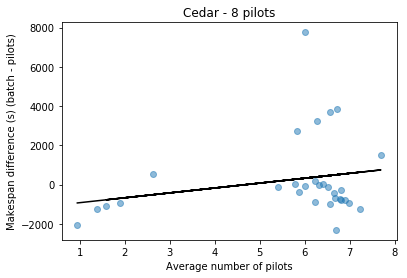

In [15]:
# 8 pilots
gf.scatter_fig([i[0] for i in avgp_8pilots],
               [i[1] for i in avgp_8pilots], 8,
               xlabel=as_xlbl.format("pilots"),
               ylabel=as_ylbl, system="Cedar")

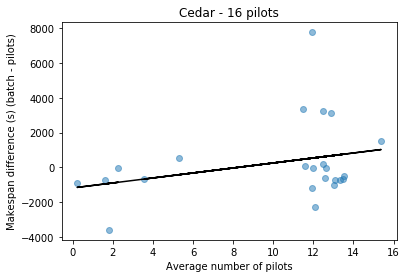

In [16]:
gf.scatter_fig([i[0] for i in avgp_16pilots],
               [i[1] for i in avgp_16pilots], 16,
               xlabel=as_xlbl.format("pilots"),
               ylabel=as_ylbl, system="Cedar")

In [17]:
batch_pilots8 = [el for el in list(zip(gf.batch, gf.pilots8))
                 if el[0]['success'] and el[1]['success']]

m1_m2_b8 = [(el[0]['end_time'] - el[0]['start_time'])
            / (el[1]['end_time'] - el[1]['start_time'])
            for el in batch_pilots8]

batch_aworkers = [(gf.get_batch_avgw(el[0])[0])
                     for el in batch_pilots8]
pilots8_aworkers = [(gf.get_pilot_avgw(el[1], el[0])[0])
                      for el in batch_pilots8]

w2_w1_b8 = [el[1] / el[0] for el in zip(batch_aworkers,
                                        pilots8_aworkers)]


In [18]:

batch_pilots16 = list(zip(gf.batch, gf.pilots16))
m1_m2_b16 = [(el[0]['end_time'] - el[0]['start_time'])
             / (el[1]['end_time'] - el[1]['start_time'])
            for el in batch_pilots16
             if el[0]['success'] and el[1]['success']]

w2_w1_b16 = [(gf.get_pilot_avgw(el[1], el[0])[0]
             / (gf.get_batch_avgw(el[0])[0]))
            for el in batch_pilots16
            if el[0]['success'] and el[1]['success']]

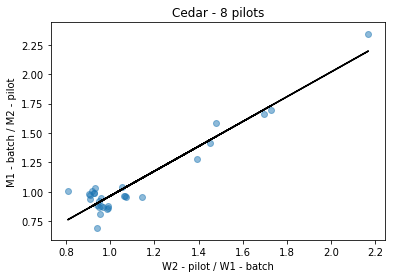

In [19]:
# 8 pilots
bm_x_lbl= "W2 - pilot / W1 - batch"
bm_y_lbl= "M1 - batch / M2 - pilot"
gf.scatter_fig(w2_w1_b8, m1_m2_b8, 8, bm_x_lbl, bm_y_lbl,
               system="Cedar")

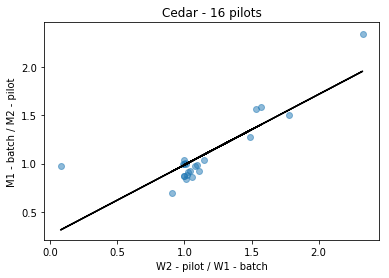

In [20]:
# 16 pilots
gf.scatter_fig(w2_w1_b16, m1_m2_b16, 16, bm_x_lbl, bm_y_lbl,
               system="Cedar")

In [42]:
import numpy as np
def basic_model(xy1, xy2, xy3, xy4, num_pilots, xlabel, ylabel, system="Beluga", save=None):   
    from matplotlib import pyplot as plt
    fig, ax = plt.subplots()                                                     
    ax.scatter(xy1[0], xy1[1], c="purple", alpha=0.5)                                                  
    ax.scatter(xy2[0], xy2[1], c="red", alpha=0.5)
    ax.scatter(xy3[0], xy3[1], c="orange", alpha=0.5)
    ax.scatter(xy4[0], xy4[1], c="green", alpha=0.5)
    
    if len(xy1) > 2:
        ax.scatter(xy1[2], xy1[3], c="purple", marker="v", alpha=0.8)                                                  
        ax.scatter(xy2[2], xy2[3], c="red", marker="v", alpha=0.8)
        ax.scatter(xy3[2], xy3[3], c="orange", marker="v", alpha=0.8)
        ax.scatter(xy4[2], xy4[3], c="green", marker="v", alpha=0.8)
    
    get_c = lambda x, y, z=False: (10*(x+20)*125)/y if z else 10*(x+20)*np.ceil(125/y)
    ceil_results = False
    n_workers = np.arange(5, 70)
    
    a = 0.3
    ax.plot(n_workers, get_c(45, n_workers, ceil_results),'+', c='purple', alpha=a)
    ax.plot(n_workers, get_c(90, n_workers, ceil_results), '+', c='red', alpha=a)
    ax.plot(n_workers, get_c(120, n_workers, ceil_results), '+', c='orange', alpha=a)
    ax.plot(n_workers, get_c(180, n_workers, ceil_results), '+', c='green', alpha=a)
    
    
    #b, m = np.polynomial.polynomial.polyfit(x, y, 1)                             
    #ax.plot(np.asarray(x), b + m*np.asarray(x), 'k-')                            
    ax.set_xlabel(xlabel)                                                        
    ax.set_ylabel(ylabel)                                                        
                                                                                 
    if save is None:                                                             
        ax.set_title('{0} - {1} pilots'.format(system, num_pilots))              
        plt.show()                                                               
    else:                                                                        
        plt.savefig(save)   

In [43]:
m_batch_1d = [el['end_time'] - el['start_time']
              for el in gf.batch if el['success']
             and "single" in el['name']]

w_batch_1d = [gf.get_batch_avgw(el)[0]
               for el in gf.batch if el['success']
               and "single" in el['name']]
m_batch_2d = [el['end_time'] - el['start_time']
              for el in gf.batch if el['success']
             and "double" in el['name']]

w_batch_2d = [gf.get_batch_avgw(el)[0]
               for el in gf.batch if el['success']
               and "double" in el['name']]

m_batch_3d = [el['end_time'] - el['start_time']
              for el in gf.batch if el['success']
             and "triple" in el['name'] and el['end_time'] is not None]

w_batch_3d = [gf.get_batch_avgw(el)[0]
               for el in gf.batch if el['success']
               and "triple" in el['name'] and el['end_time'] is not None]

m_batch_4d = [el['end_time'] - el['start_time']
              for el in gf.batch if el['success']
             and "quadruple" in el['name']]

w_batch_4d = [gf.get_batch_avgw(el)[0]
               for el in gf.batch if el['success']
               and "quadruple" in el['name']]

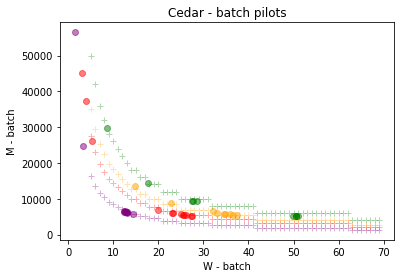

In [44]:
basic_model((w_batch_1d, m_batch_1d),
             (w_batch_2d, m_batch_2d),
             (w_batch_3d, m_batch_3d), (w_batch_4d, m_batch_4d),"batch",
               "W - batch", "M - batch",
               system="Cedar")

In [45]:
m_8p_1d = [(el['end_time'] - el['start_time'])
            for el in gf.pilots8 if el['success']
          and '1d' in el['name']]

w_8p_1d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots8 if el['success']
           and '1d' in el['name']]

m_8p_2d = [(el['end_time'] - el['start_time'])
            for el in gf.pilots8 if el['success']
          and '2d' in el['name']]

w_8p_2d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots8 if el['success']
           and '2d' in el['name']]
m_8p_3d = [(el['end_time'] - el['start_time'])
            for el in gf.pilots8 if el['success']
          and '3d' in el['name']]

w_8p_3d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots8 if el['success']
           and '3d' in el['name']]

m_8p_4d = [(el['end_time'] - el['start_time'])
            for el in gf.pilots8 if el['success']
          and '4d' in el['name']]

w_8p_4d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots8 if el['success']
           and '4d' in el['name']]

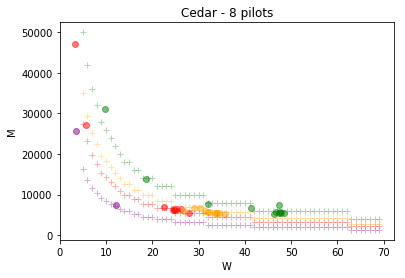

In [46]:
basic_model((w_8p_1d, m_8p_1d),
            (w_8p_2d, m_8p_2d),
            (w_8p_3d, m_8p_3d), (w_8p_4d, m_8p_4d), 8,
               "W", "M",
               system="Cedar")

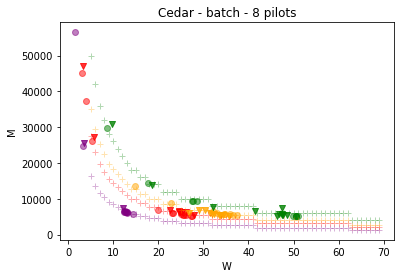

In [51]:
basic_model((w_batch_1d, m_batch_1d, w_8p_1d, m_8p_1d),
            (w_batch_2d, m_batch_2d, w_8p_2d, m_8p_2d),
            (w_batch_3d, m_batch_3d, w_8p_3d, m_8p_3d),
            (w_batch_4d, m_batch_4d, w_8p_4d, m_8p_4d), "batch - 8", "W", "M",
            system="Cedar")

In [48]:
m_16p_1d = [(el['end_time'] - el['start_time'])
        for el in gf.pilots16 if el['success']
           and '1d' in el['name']]
w_16p_1d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots16 if el['success']
           and '1d' in el['name']]
m_16p_2d = [(el['end_time'] - el['start_time'])
        for el in gf.pilots16 if el['success']
           and '2d' in el['name']]
w_16p_2d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots16 if el['success']
           and '2d' in el['name']]
m_16p_3d = [(el['end_time'] - el['start_time'])
        for el in gf.pilots16 if el['success']
           and '3d' in el['name']]
w_16p_3d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots16 if el['success']
           and '3d' in el['name']]
m_16p_4d = [(el['end_time'] - el['start_time'])
        for el in gf.pilots16 if el['success']
           and '4d' in el['name']]
w_16p_4d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots16 if el['success']
           and '4d' in el['name']]


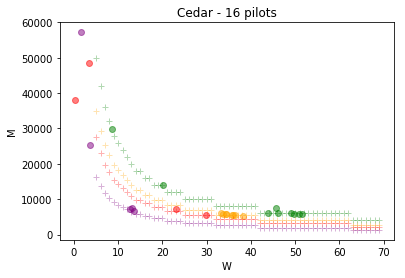

In [49]:
basic_model((w_16p_1d, m_16p_1d),
                (w_16p_2d, m_16p_2d),
                (w_16p_3d, m_16p_3d), (w_16p_4d, m_16p_4d), 16,
               "W", "M",
               system="Cedar")

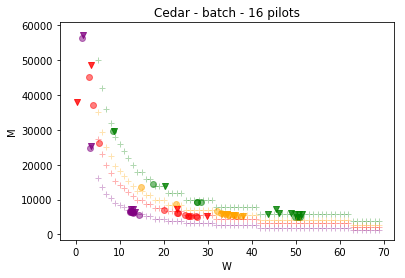

In [52]:
basic_model((w_batch_1d, m_batch_1d, w_16p_1d, m_16p_1d),
            (w_batch_2d, m_batch_2d, w_16p_2d, m_16p_2d),
            (w_batch_3d, m_batch_3d, w_16p_3d, m_16p_3d),
            (w_batch_4d, m_batch_4d, w_16p_4d, m_16p_4d), "batch - 16", "W", "M",
            system="Cedar")